<h1> ML PROJECT DEADLINE -2 </h1>

In [1]:
from PIL import Image
from numpy import random
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from skimage import exposure
from skimage import feature, io
from sklearn.preprocessing import MinMaxScaler
import os
import shutil
import pandas as pd
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as custom_plot
import random

def path_join(a,b):
    return a+"/"+b

In [2]:
source_folder="Human_Action_Recognition/train/" # Path to the original training folder containing images
csv_file="Human_Action_Recognition/Training_set.csv" # Path to the CSV file
new_structured_folder="Human_Action_Recognition_organized/"
df=pd.read_csv(csv_file)


# create seperate subfolders for each image class
classes=["sitting","using_laptop","hugging","sleeping","drinking","clapping","dancing","calling","cycling","laughing","fighting","eating","listening_to_music","texting","running"]
classes_to_label={'calling':0, 'clapping':1, 'cycling':2, 'dancing':3, 'drinking':4, 'eating':5, 'fighting':6, 'hugging':7, 'laughing':8, 'listening_to_music':9, 'running':10, 'sitting':11, 'sleeping':12, 'texting':13, 'using_laptop':14}
label_to_classes={0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}

class_to_images={} # maps a class to all the image paths in it
images_to_class={}


for a in classes:
    class_to_images[a]=[]
   


for idx,row in df.iterrows(): 
    image_name=row['filename']
    label=row['label']
    curr_image_subfolder=new_structured_folder+label

  
    src_path=source_folder+image_name
    dest_path=path_join(curr_image_subfolder,image_name)
    
    class_to_images[label].append(dest_path)
    images_to_class[image_name]=label


img_list=list(images_to_class.keys())

<br><br>
<h3>Computing Histogram of Oriented Features (HOG) to get silhoutte of the image</h3>

In [3]:
# flag=0 : means image_path
# flag=1 : means image directly (send in grayscale)
def calculate_hog_features(image_path,flag,plot=0):
    

    if (flag==0):
        image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    else: image=image_path
    
    image=cv2.resize(image, (64,128))
    # custom_plot.imshow(image,cmap="gray")
     
    # Calculate HOG features
    fd,hog_feature=hog(image,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(2, 2),block_norm='L2-Hys',visualize=True)                                                            
    rescaled_hog_image=exposure.rescale_intensity(hog_feature, in_range=(0, 10))  # Rescale HOG features for better visualization


    if (plot==1):
        custom_plot.figure(figsize=(8, 4))
        custom_plot.subplot(121)
        custom_plot.imshow(image, cmap=custom_plot.cm.gray)
        custom_plot.title('Original Image')
        custom_plot.axis('off')
                                                                                       
        # Display the HOG image
        custom_plot.subplot(122)
        custom_plot.imshow(rescaled_hog_image, cmap=custom_plot.cm.gray)
        custom_plot.title('HOG Features')
        custom_plot.axis('off')

        # Show the images
        custom_plot.show()
        
    return fd

<br><br>
<h3>Edge Detection Filter</h3>

In [4]:
def apply_sobels_edge(img_path,flag=0,plot=0):
    
    if (flag==0): img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    else : img=img_path
    
    # img=cv2.resize(img, (1,128))
    blurred1= cv2.GaussianBlur(img, (9, 9), 0)
    blurred2=cv2.bilateralFilter(img, 11,75,200) 
    # blurred1=img
    # blurred2=img
    
    


    # Apply the Sobel filter for edge detection
    sobels_edges1_x=cv2.Sobel(blurred1,cv2.CV_64F,1,0,ksize=3)  # Sobel filter for detecting horizontal edges
    sobels_edges1_y=cv2.Sobel(blurred1,cv2.CV_64F,0,1,ksize=3)  # Sobel filter for detecting vertical edges
    edges1=np.sqrt(sobels_edges1_x**2+sobels_edges1_y**2)   # Combine the horizontal and vertical edges to obtain the magnitude
    edges1=cv2.normalize(edges1,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U) # Normalize the edge magnitude for better visualization
    
    sobels_edges2_y=cv2.Sobel(blurred2,cv2.CV_64F,0,1,ksize=3)  # Sobel filter for detecting vertical edges
    sobels_edges2_x=cv2.Sobel(blurred2,cv2.CV_64F,1,0,ksize=3)  # Sobel filter for detecting horizontal edges
    edges2=np.sqrt(sobels_edges2_x**2+sobels_edges2_y**2)   # Combine the horizontal and vertical edges to obtain the magnitude
    edges2=cv2.normalize(edges2,None,0,255,cv2.NORM_MINMAX,cv2.CV_8U) # Normalize the edge magnitude for better visualization


    if (plot==1):
        # Display the original image and the edge map
        # custom_plot.figure(figsize=(100, 100))
        fig, axes = custom_plot.subplots(1, 5, figsize=(16, 4))
        custom_plot.subplot(151),
        axes[0].imshow(img, cmap='gray')
        axes[0].axis('off')
        axes[0].set_title('Original Image')
        
        axes[1].imshow(blurred1, cmap='gray')
        axes[1].axis('off')
        axes[1].set_title('Gaussian Blurred Image')
        
        axes[2].imshow(edges1, cmap='gray')
        axes[2].axis('off')
        axes[2].set_title('Gaussian Edges')
        
        axes[3].imshow(blurred2, cmap='gray')
        axes[3].axis('off')
        axes[3].set_title('Bilateral Blurred Image')
        
        axes[4].imshow(edges2, cmap='gray')
        axes[4].axis('off')
        axes[4].set_title('Bilateral Edges')
    
    return edges2

<br><br> <h3>Convert To HSV space and calculate colour based histograms</h3>

In [5]:
# Convert the image to the HSV color space

def calculate_hsv_features(image_path,plot=0):
    img=Image.open(image_path)
    hsv_image=img.convert('HSV')

    # Convert the PIL image to a NumPy array for further processing
    image_array=np.array(hsv_image)

    hist_hue=np.histogram(image_array[:, :, 0], bins=256, range=(0, 256))
    hist_saturation=np.histogram(image_array[:, :, 1], bins=256, range=(0, 256))
    hist_value=np.histogram(image_array[:, :, 2], bins=256, range=(0, 256))

    # Concatenate the histograms
    color_histogram_feature=np.concatenate((hist_hue[0],hist_saturation[0],hist_value[0])).flatten()

    if (plot==1):
        custom_plot.figure(figsize=(12, 4))
        custom_plot.subplot(131)
        custom_plot.plot(hist_hue[0])
        custom_plot.title('Hue Histogram')
        custom_plot.subplot(132)
        custom_plot.plot(hist_saturation[0])
        custom_plot.title('Saturation Histogram')
        custom_plot.subplot(133)
        custom_plot.plot(hist_value[0])
        custom_plot.title('Value Histogram')
        custom_plot.show()

    return color_histogram_feature

<br><br><br>
<h3>LBP FEATURES </h3>

In [6]:
def calculate_lbp_features(old_path,plot=0):
    img=cv2.imread(old_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    lbp_features=feature.local_binary_pattern(gray, P=16, R=2, method='uniform')

    # Calculate histogram
    hist, _ = np.histogram(lbp_features, bins=np.arange(0, 256), range=(0, 255))
    
    if (plot==1):
        custom_plot.figure(figsize=(10, 5))
        custom_plot.subplot(121), custom_plot.imshow(gray, cmap='gray')
        custom_plot.title('Original Image')
        custom_plot.subplot(122), custom_plot.imshow(lbp_features, cmap='gray')
        custom_plot.title('LBP image')
        custom_plot.show()
 
    return hist

<br><br><br>
<h3>TRAIN ON WHOLE DATA</h3>

In [ ]:
# RBF kernel(Gaussian)
# C - regularization : high C means less training error(may overfit) and low means better margin
# Gamma - complex decision bdry: high gamma means smooth and capture only points at bdrys (overfit) , large also takes wiggly points 

In [7]:
def feature_extraction(curr_img_path):
    curr_hog_features=calculate_hog_features(curr_img_path,flag=0)
    curr_hsv_features=calculate_hsv_features(curr_img_path)
    curr_lbp_features=calculate_lbp_features(curr_img_path)
    features=np.concatenate((curr_hog_features,curr_hsv_features,curr_lbp_features))
    return features
    

In [8]:
# Extract HOG features from the raw image data
X=[]
Y=[]
for a in os.listdir(new_structured_folder):
    curr_class_path=new_structured_folder+a
    for b in os.listdir(curr_class_path):
        curr_img_path=path_join(curr_class_path,b)
        features=feature_extraction(curr_img_path)
        X.append(features)
        Y.append(classes_to_label[a])
        

X_train=np.array(X)
Y_train=np.array(Y)


scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)

svm_classifier=SVC(kernel='poly',degree=6,C=10,gamma=1)
svm_classifier.fit(X_train, Y_train)


SVC(C=10, degree=6, gamma=1, kernel='poly')

In [9]:
# import pickle

# with open('X_train.pkl', 'wb') as file:
#     pickle.dump(X_train, file)
    
# with open('scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)
    
# with open('svm_model.pkl', 'wb') as file:
#     pickle.dump(svm_classifier, file)
    

eating
sitting
eating
laughing
texting
cycling
drinking
listening_to_music


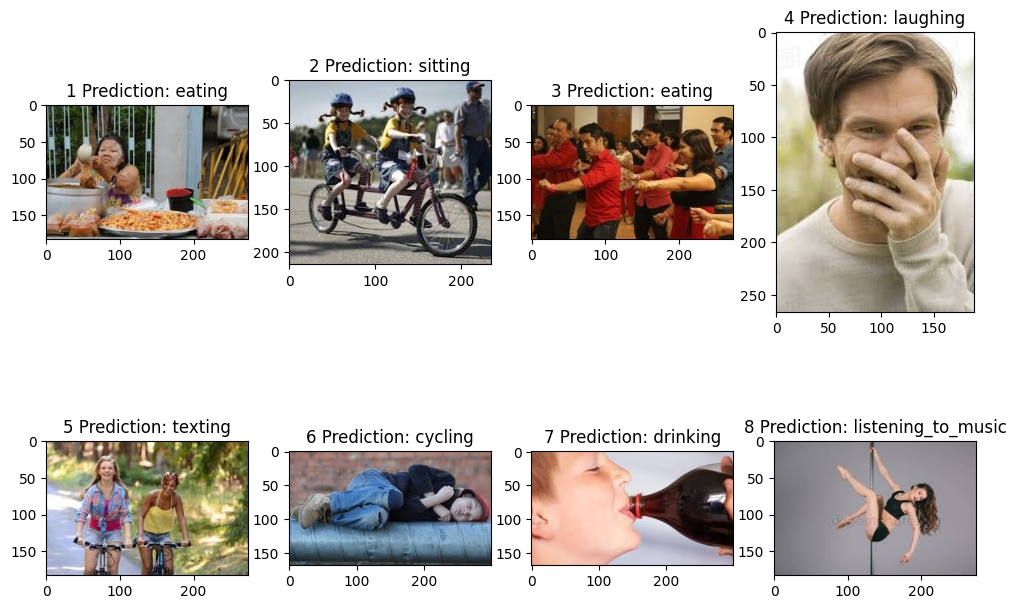

In [31]:
with open('scaler.pkl', 'rb') as file:
    scaler=pickle.load(file)
    
with open('svm_model.pkl', 'rb') as file:
    svm_classifier=pickle.load(file)


file_path="Human_Action_Recognition/test/"
paths=[]
random_numbers = random.sample(range(1, 5401), 8)
for a in random_numbers:
    paths.append(file_path+f"Image_{a}.jpg")
    
    
fig, axes = custom_plot.subplots(2,4, figsize=(12, 8))
i=0

for path in paths:
    
    features=feature_extraction(path)
    features_scaled=scaler.transform(features.reshape(1, -1))
    prediction=svm_classifier.predict(features_scaled)
    
    img=Image.open(path)
    ax = axes[i // 4, i % 4] if 4 > 1 else axes
    ax.imshow(img)
    ax.set_title(f"{i+1} Prediction: {label_to_classes[prediction[0]]}")
    print(label_to_classes[prediction[0]])
    i+=1
    
   

<br><br><br>
<h3>TESTING SCRIPT </h3>

In [ ]:
with open('scaler.pkl', 'rb') as file:
    scaler=pickle.load(file)
    
with open('svm_model.pkl', 'rb') as file:
    svm_classifier=pickle.load(file)


file_path="file.txt"
# for a in os.listdir(file_path):
file=open(file_path,'r')
l=file.readlines()
fig, axes = custom_plot.subplots(2,4, figsize=(12, 8))
i=0

for a in l: 
    b=a.strip()
    path=b
    
    features=feature_extraction(path)
    features_scaled=scaler.transform(features.reshape(1, -1))
    prediction=svm_classifier.predict(features_scaled)
    
    img=Image.open(path)
    ax = axes[i // 4, i % 4] if 4 > 1 else axes
    ax.imshow(img)
    ax.set_title(f"{i+1} Prediction: {label_to_classes[prediction[0]]}")
    print(label_to_classes[prediction[0]])
    i+=1
    


K - CROSS VALIDATION

In [9]:
# Extract HOG features from the raw image data

X=[] 
Y=[] 
for a in os.listdir(new_structured_folder):
    curr_class_path=new_structured_folder+a
    for b in os.listdir(curr_class_path):
        curr_img_path=path_join(curr_class_path,b)
        curr_features=calculate_hog_features(curr_img_path)
        X.append(curr_features)
        Y.append(classes_to_label[a])

X=np.array(X)
Y=np.array(Y)
    


svm_classifier=SVC(kernel='poly',degree=6,C=10,gamma=1)
scores = cross_val_score(svm_classifier, X, Y, cv=5)
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

Cross-validation scores: [0.32579365 0.30515873 0.31111111 0.31349206 0.31071429]
Average accuracy: 0.31325396825396823


<br><br><hr>

In [ ]:

# 1) hsv features (768 FEATURES) -> 2min to train and 0.5 min to test -> 2min
# hsv features  - SVM (C=10, gamma=1, rbf) -> 7.96%
# hsv features  - SVM (C=10, gamma=1, poly) -> 20.6%



# 2)Edge map -> 17%



# 3) HOG features(image resize to (128x64) with (3780 FEATURES)->16min train & 5min to test -> 21min
# hog feature - SVM (C=10 , gamma=1 , poly, degree=6) -> 32% (16+2min) optimal
# normalize - 31.6%
# hog feature - SVM (C=10 , gamma=1 , poly, degree=6) with bilateral filter-> 30.4% (min) 
# hog feature - SVM (C=10 , gamma=1 , poly, degree=10) -> 25%
# hog feature pca (1500 features) - SVM (C=10 , gamma=1 , poly) -> 10% 




# 4)SIFT features 



# 5) HOG + hsv features (4585 FEATURES) -> 20min to train & 5min to test -> 25min    
# hog + hsv feature - SVM (C=10 , gamma=1 , poly) -> 20.6%
# hog + hsv feature normalized - SVM (C=10 , gamma=1 , poly) -> 33.7%  (25min)
# hog + hsv feature +lbp normalized - SVM (C=10 , gamma=1 , poly) -> 34.4%  (31min)

# Gaussian blur + canny -> normalized hog +hsv -> 28.7%



# Use ensemble (hsv,hog) -> 32%


In [ ]:
# Custom train test split - 30.6% (25min)
# Sklearn train-test split - 32%   (25min)
# sklearn k-cross validation - 31% (50mins)

# PCA with inverse transform (naive hog 3400 to 1900)-> 32% 

In [ ]:
# EVEN CNNS are 70% only 

# 1)Normalized hog + hsv + lbp (~4500 features) -> 34.5% 
# 2)Bilateral blur (noise reduction) + sobel(bg seperation) -> normalized hog + hsv + lbp -> 30.8%
#   Bilateral blur (noise reduction) + canny(bg seperation) -> normalized hog + hsv -> 28%

# 3)Ensemble hog , hsv -> 31% 
# 4)SIFT - very high dimensionality (PCA and scale not working)
# 5) mean and variance of HOG features on upscaled images -> 30%
# Min-Max Scaler boosted accuracy by 2%

# 5)KERNELS 
# gaussian- 
# expo-  
# Laplacian- 
# poly- 
# linear- 
# sigmoid- 

# 6)Techniques tried
# Noise reduction- Gaussian filter , bilateral fiter , Median filter (~succesfull)
# Bg seperation - Template matching , contours , Canny/Sobel filters  (~succesfull)


